# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

<h6>Importing Library and reading files </h6>

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
sns.set()

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<h6>Tacking a snap pick to data</h6>

In [2]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [3]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [4]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


<h3>First portfolio dataset </h3>

In [5]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
print('The number of columns {} and the number of rows are {}'.format(portfolio.shape[1],portfolio.shape[0]))

The number of columns 6 and the number of rows are 10


In [7]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [8]:
#checking for null value in dataset 
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [9]:
#checking for duplicate value in dataset 
portfolio.columns.duplicated().sum()

0

In [10]:
# checking the number of unique offers
portfolio['id'].nunique()

10

In [11]:
# counting the offers by their type 
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

<h5>The above preliminary Exploration for the Portfolio Dataset shows the following:</h5>
The dataset has 6 columns and 10 rows.<br>
This dataset has no null values nor duplicates.<br>
There are three types of offers : 'bogo', 'informational' and 'discount'.<br>
The 'difficulty' column unit is dollars , which does not reflect how difficult to be rewarded. Rescaling this feature is a useful step to do. This needs to be done before Modeling.

<h3>secound profile dataset </h3>


In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
print('The number of columns {} and the number of rows are {}'.format(profile.shape[1],profile.shape[0]))

The number of columns 5 and the number of rows are 17000


In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [15]:
#checking for null value in dataset 
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
#checking for duplicate value in dataset 
profile.columns.duplicated().sum()

0

In [17]:
#checking unique customer 
len(profile['id'].unique())

17000

In [18]:
#finding count of gender categories
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

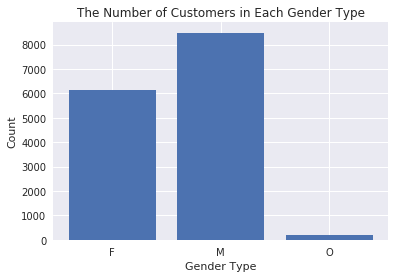

In [19]:
profile_gender_counts = profile.gender.value_counts()
x = ['M','F','O']
data = profile_gender_counts
plt.bar(x,height = data);
plt.xlabel('Gender Type');
plt.ylabel('Count');
plt.title('The Number of Customers in Each Gender Type');

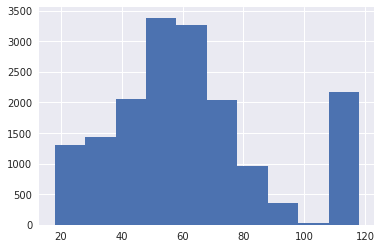

In [20]:
#checking age columns 
plt.hist(profile['age'], bins=10);

In [21]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

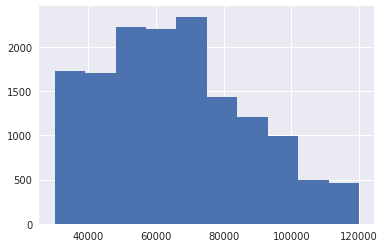

In [22]:
# checking income columns
profile['income'].hist();

<h5>The above preliminary Exploration for the profile Dataset shows the following:</h5>
The dataset has 5 columns and 17000 rows.<br>
This dataset has no duplicates.<br>
The dataset has 2175 missing values on each of: ‘gender’, ’income’ variables.<br>
We can say that we have more man than women in this dataset.<br>
The median of costmer age is 58 years old, also we can found that we have a maximum 118.<br>


<h3>third Transcript dataset </h3>


In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [24]:
print('The number of columns {} and the number of rows are {}'.format(transcript.shape[1],transcript.shape[0]))

The number of columns 4 and the number of rows are 306534


In [25]:
#checking for null value in dataset 
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [26]:
#checking for duplicate value in dataset 
transcript.columns.duplicated().sum()

0

In [27]:
#Type of event counts
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [28]:
transcript[transcript['event']=='transaction']

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}
12678,transaction,629fc02d56414d91bca360decdfa9288,0,{'amount': 33.9}
12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,{'amount': 0.22}
12687,transaction,a97e6f33219c432db82acfa0d19c602d,0,{'amount': 18.59}
12691,transaction,676506bad68e4161b9bbaffeb039626b,0,{'amount': 18.01}
12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'amount': 19.11}


<h5>The above Exploration for the Transcript Dataset shows the following:</h5>
The dataset has 4 columns and 306,534 rows.<br>
The dataset has no duplicated rows nor missing values.<br>
The ‘value’ column is a dictionary.<br>
There are four types of events in this dataset: ‘transaction’, ’ offer received’, ‘offer viewed’ and ‘offer completed’.<br>
All the events that are classified as ‘transaction’ do not have an ‘offerid’ within its ‘value’ column.

<h3> Data Processing </h3>

For Portfolio Dataset:<br>
<li>Rename 'id' column to 'offer_id'.
<li>Change the unit of 'duration' column from days to hours.
<li>Rename 'duration' column to 'duration_h' representing that the unit of measurment is 'hours'
<li>Create dummy variables from the 'channels' column
<li>Replace the 'offer_id' by more easy ids.
<li>Replace the 'offer_type' by integers representing each offer type as follow:<br>
bogo = 1<br>
discount = 2<br>
informational = 3<br>
<li>Normalize 'difficulty' and 'reward' features using the MinMaxScaler

In [29]:
# creating a copy of the dataset
clean_portfolio = portfolio.copy()

<li>Rename 'id' column to 'offer_id'

In [30]:
clean_portfolio.rename(columns={'id':'offer_id'},inplace=True)

<li>Change the unit of 'duration' column from days to hours

In [31]:
clean_portfolio['duration'] = clean_portfolio['duration']*24

<li>Rename 'duration' column to 'duration_h' representing that the unit of measurment is 'hours'

In [32]:
clean_portfolio.rename(columns={'duration':'duration_h'},inplace=True)

<li>Create dummy variables from the 'channels' column 

In [33]:
#creating the dummy 
clean_portfolio['channel_email'] = clean_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
clean_portfolio['channel_mobile'] = clean_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
clean_portfolio['channel_social'] = clean_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
clean_portfolio['channel_web'] = clean_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [34]:
#takeing a look of change 
clean_portfolio[['channels','channel_email','channel_mobile','channel_web','channel_social']].head()

,channels,channel_email,channel_mobile,channel_web,channel_social
0,"[email, mobile, social]",1,1,0,1
1,"[web, email, mobile, social]",1,1,1,1
2,"[web, email, mobile]",1,1,1,0
3,"[web, email, mobile]",1,1,1,0
4,"[web, email]",1,0,1,0


In [35]:
#droping columns 
clean_portfolio.drop('channels', axis=1, inplace=True)

In [36]:
#checking dataset after creating changes
clean_portfolio.head()

,difficulty,duration_h,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


<li>Replace the 'offer_id' by more easy ids

In [37]:
labels_offer_id = clean_portfolio['offer_id'].astype('category').cat.categories.tolist() # replacing the 'offer_id' by more easy ids
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
clean_portfolio.replace(replace_map_comp_offer_id, inplace=True)# replacing the categorical values in the 'offer_id' column by numberical values

In [38]:
clean_portfolio

,difficulty,duration_h,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,168,8,bogo,10,1,1,1,0
1,10,120,5,bogo,10,1,1,1,1
2,0,96,4,informational,0,1,1,0,1
3,5,168,7,bogo,5,1,1,0,1
4,20,240,1,discount,5,1,0,0,1
5,7,168,2,discount,3,1,1,1,1
6,10,240,10,discount,2,1,1,1,1
7,0,72,6,informational,0,1,1,1,0
8,5,120,9,bogo,5,1,1,1,1
9,10,168,3,discount,2,1,1,0,1


<li>Replace the 'offer_type' by integers representing each offer type as follow: bogo discount informational

In [39]:
labels_offer_type = clean_portfolio['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
clean_portfolio.replace(replace_map_comp_offer_type, inplace=True)

In [40]:
clean_portfolio

,difficulty,duration_h,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,168,8,1,10,1,1,1,0
1,10,120,5,1,10,1,1,1,1
2,0,96,4,3,0,1,1,0,1
3,5,168,7,1,5,1,1,0,1
4,20,240,1,2,5,1,0,0,1
5,7,168,2,2,3,1,1,1,1
6,10,240,10,2,2,1,1,1,1
7,0,72,6,3,0,1,1,1,0
8,5,120,9,1,5,1,1,1,1
9,10,168,3,2,2,1,1,0,1


<li> Normalize 'difficulty' and 'reward' features using the MinMaxScaler

In [41]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['difficulty','reward']

#features_log_minmax_transform 
clean_portfolio[numerical] = scaler.fit_transform(clean_portfolio[numerical])

# Show an example of a record with scaling applied
clean_portfolio.head()

,difficulty,duration_h,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,0.50,168,8,1,1.0,1,1,1,0
1,0.50,120,5,1,1.0,1,1,1,1
2,0.00,96,4,3,0.0,1,1,0,1
3,0.25,168,7,1,0.5,1,1,0,1
4,1.00,240,1,2,0.5,1,0,0,1


For Profile Dataset:<br>

In [42]:
#taken a copy of the dataset
clean_profile = profile.copy()

In [43]:
clean_profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


<h5>will begin with ID columns:</h5>
<li> Will change columns name
<li>will replace the value of customer id with somthing numerical and easy to deal with

In [44]:
# renaming 'id' column name to 'customer_id'.
clean_profile.rename(columns={'id':'customer_id'},inplace=True)

In [45]:
# replacing the 'customer_id' string values  with easiest numerical values
labels_customer_id = clean_profile['customer_id'].astype('category').cat.categories.tolist()
replace_map_comp_customer_id = {'customer_id' : {k: v for k,v in zip(labels_customer_id,list(range(1,len(labels_customer_id)+1)))}}
clean_profile.replace(replace_map_comp_customer_id, inplace=True)

In [46]:
clean_profile.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,6962,NaN
1,55,20170715,F,399,112000.0
2,118,20180712,None,3747,NaN
3,75,20170509,F,7997,100000.0
4,118,20170804,None,10736,NaN


<h5>Then age columns:</h5>
<li> Will replace the age 118 with nan
<li>droping rows with null value
<li>changing the datatype for age and income columns 
<li>creating an age categories and range 
    <ol>teenager= 1
    <ol>young-adult= 2
    <ol>adult= 3
    <ol>elderly= 4

In [47]:
# replacing the age = 118 by NaN value
clean_profile['age'] = clean_profile['age'].apply(lambda x: np.nan if x == 118 else x)

In [48]:
# dropping rows with NaNs in 'age', 'gender' and 'income' columns
clean_profile.dropna(inplace=True)

In [49]:
# changing the datatype of 'age' and 'income' columns to 'int'
clean_profile[['age','income']] = clean_profile[['age','income']].astype(int)

In [50]:
# creating a new column representing the age group to which the customer belongs 
clean_profile['age_group'] = pd.cut(clean_profile['age'], bins=[17, 22, 35, 60, 103],labels=['teenager', 'young-adult', 'adult', 'elderly'])

In [51]:
# replacing the 'age_group' categorical labels by numerical labels
labels_age_group = clean_profile['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
clean_profile.replace(replace_map_comp_age_group, inplace=True)

In [52]:
clean_profile.head()

,age,became_member_on,gender,customer_id,income,age_group
1,55,20170715,F,399,112000,3
3,75,20170509,F,7997,100000,4
5,68,20180426,M,15044,70000,4
8,65,20180209,M,3729,53000,4
12,58,20171111,M,3060,51000,3


<h5>Then income columns:</h5>
<li> Will have new columns with income group 
<ol>average = 1
<ol>above_average= 2
<ol>high= 3

In [53]:
# creating a new column representing the income group to which the customer belongs 
clean_profile['income_range'] = pd.cut(clean_profile['income'], bins=[29999, 60000, 90000, 120001],labels=['average', 'above-average', 'high'])

In [54]:
# replacing the 'income_range' categorical labels by numerical labels
labels_income_range = clean_profile['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range = {'income_range' : {k: v for k,v in zip(labels_income_range,list(range(1,len(labels_income_range)+1)))}}
clean_profile.replace(replace_map_comp_income_range, inplace=True)

<h5>Then gender columns:</h5>
<li> Will change the string into numeric values
<ol> F = 1
<ol> M = 2
<ol> O = 3

In [55]:
labels_gender = clean_profile['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
clean_profile.replace(replace_map_comp_gender, inplace=True)

In [56]:
clean_profile.head()

,age,became_member_on,gender,customer_id,income,age_group,income_range
1,55,20170715,1,399,112000,3,3
3,75,20170509,1,7997,100000,4,3
5,68,20180426,2,15044,70000,4,2
8,65,20180209,2,3729,53000,4,1
12,58,20171111,2,3060,51000,3,1


Then became_member_on columns:
<li>Will change the datatype of the columns into date
<li>will have new columns with the start member ship year
<li>will have a new columns that count days since register
<li>will reindex dataset columns 
<li>then will create a new columns with member type based on membership days :
<ol>new (memebr since 1000 days or less) = 1
<ol>regular (1001 - 1,600 days of membership) = 2
<ol>loyal (more than 1,600 days of membership) = 3

In [57]:
# changing the datatype of 'became_member_on' column from int to date 
clean_profile['became_member_on'] = pd.to_datetime(clean_profile['became_member_on'], format = '%Y%m%d')

In [58]:
# adding a new column 'start_year'
clean_profile['membership_year'] = clean_profile['became_member_on'].dt.year

In [59]:
# adding a new column 'membership_days' 
clean_profile['membership_days'] = datetime.datetime.today().date() - clean_profile['became_member_on'].dt.date
# removing the 'days' unit
clean_profile['membership_days'] = clean_profile['membership_days'].dt.days

In [60]:
clean_profile.head()

,age,became_member_on,gender,customer_id,income,age_group,income_range,membership_year,membership_days
1,55,2017-07-15,1,399,112000,3,3,2017,2102
3,75,2017-05-09,1,7997,100000,4,3,2017,2169
5,68,2018-04-26,2,15044,70000,4,2,2018,1817
8,65,2018-02-09,2,3729,53000,4,1,2018,1893
12,58,2017-11-11,2,3060,51000,3,1,2017,1983


In [61]:
clean_profile['member_type'] = pd.cut(clean_profile['membership_days'], bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])
labels_member_type = clean_profile['member_type'].astype('category').cat.categories.tolist()
replace_map_comp_member_type = {'member_type' : {k: v for k,v in zip(labels_member_type,list(range(1,len(labels_member_type)+1)))}}
clean_profile.replace(replace_map_comp_member_type, inplace=True)


In [62]:
clean_profile.drop(columns = ['age','income','became_member_on', 'membership_days'], axis=1, inplace=True)

In [63]:
clean_profile.head()

,gender,customer_id,age_group,income_range,membership_year,member_type
1,1,399,3,3,2017,3
3,1,7997,4,3,2017,3
5,2,15044,4,2,2018,3
8,2,3729,4,1,2018,3
12,2,3060,3,1,2017,3


In [64]:
clean_profile.columns

Index(['gender', 'customer_id', 'age_group', 'income_range', 'membership_year',
       'member_type'],
      dtype='object')

In [65]:
#reindex columns for the dataset
clean_profile = clean_profile.reindex(columns=['customer_id', 'gender', 'age_group', 'income_range', 'member_type','membership_year'])

In [66]:
clean_profile.head()

,customer_id,gender,age_group,income_range,member_type,membership_year
1,399,1,3,3,3,2017
3,7997,1,4,3,3,2017
5,15044,2,4,2,3,2018
8,3729,2,4,1,3,2018
12,3060,2,3,1,3,2017


<h3>Transcript Dataset</h3>

In [67]:
#take a copy of the dataset
clean_transcript = transcript.copy()

In [68]:
clean_transcript.rename(columns={'person':'customer_id'},inplace=True) #change person columns to customer id
clean_transcript.replace(replace_map_comp_customer_id, inplace=True) #change the data into numeric values 

In [69]:
clean_transcript.head() #checking dataset

,event,customer_id,time,value
0,offer received,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [70]:
# Extract each key that exist in 'value' column to a seperate column.
# getting the different keys  that exists in the 'value' column
keys = []
for idx, row in clean_transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

In [71]:
keys

['offer id', 'amount', 'offer_id', 'reward']

In [72]:
#create columns and we have to specify the datatype of each of them
clean_transcript['offer_id'] = '' # datatype : string
clean_transcript['amount'] = 0  # datatype : integer
clean_transcript['reward'] = 0  # datatype : integer

In [73]:
# repeated over clean_transcript dataset and checking 'value' column
# then updating it and using the values to fill in the columns created above
for idx, row in clean_transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id': # b/c 'offer_id' and 'offer id' are representing the same thing 
            clean_transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            clean_transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            clean_transcript.at[idx, 'reward'] = row['value'][k]

In [74]:
clean_transcript['offer_id'] = clean_transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)# filling all the NaNs in the 'offer_id' column with 'N/A' values 
clean_transcript.drop('value', axis=1, inplace=True)# dropping the 'value' column

In [75]:
clean_transcript.head()

,event,customer_id,time,offer_id,amount,reward
0,offer received,7997,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,10736,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,15044,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,9525,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,6940,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [76]:
clean_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [77]:
#we will focus on 'offer viewed' or 'offer completed' since we need to focus on customer who sow the 'offer viewed' and complated.
# tacking out all events of 'transaction' , 'offer received' from our clean_transcript dataset
clean_transcript = clean_transcript[clean_transcript['event'] != 'transaction'] 
clean_transcript = clean_transcript[clean_transcript['event'] != 'offer received']

In [78]:
clean_transcript['event'].unique()

array(['offer viewed', 'offer completed'], dtype=object)

In [79]:
# replacing the 'event' categorical labels with coressponding numerical label
#key will be for 'offer completed' = 1 and  'offer viewed' = 2
labels_event = clean_transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
clean_transcript.replace(replace_map_comp_event, inplace=True)

In [80]:
clean_transcript.head()

,event,customer_id,time,offer_id,amount,reward
12650,2,3729,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
12651,2,13995,0,5a8bc65990b245e5a138643cd4eb9837,0,0
12652,2,1052,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
12653,2,170,0,ae264e3637204a6fb9bb56bc8210ddfd,0,0
12655,2,12744,0,5a8bc65990b245e5a138643cd4eb9837,0,0


In [81]:
clean_transcript.replace(replace_map_comp_offer_id, inplace=True)#replacing offer_id with numeric value 
clean_transcript.head()

,event,customer_id,time,offer_id,amount,reward
12650,2,3729,0,9,0,0
12651,2,13995,0,6,0,0
12652,2,1052,0,5,0,0
12653,2,170,0,8,0,0
12655,2,12744,0,6,0,0


<h2>Merging the three clean datasets into master table</h2>

In [82]:
master_df = pd.merge(clean_transcript,clean_portfolio,how='left',on='offer_id')#will merge 'transcript' with 'portfolio' on 'offer_id'

In [83]:
master_df = pd.merge(master_df,clean_profile,how='left',on='customer_id')#will merge our master table  with 'profile' on 'customer_id'

In [84]:
master_df.head()

,event,customer_id,time,offer_id,amount,reward_x,difficulty,duration_h,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web,gender,age_group,income_range,member_type,membership_year
0,2,3729,0,9,0,0,0.25,120,1,0.5,1,1,1,1,2.0,4.0,1.0,3,2018.0
1,2,13995,0,6,0,0,0.00,72,3,0.0,1,1,1,0,3.0,3.0,1.0,3,2017.0
2,2,1052,0,5,0,0,0.50,120,1,1.0,1,1,1,1,1.0,4.0,1.0,3,2016.0
3,2,170,0,8,0,0,0.50,168,1,1.0,1,1,1,0,1.0,1.0,1.0,3,2016.0
4,2,12744,0,6,0,0,0.00,72,3,0.0,1,1,1,0,2.0,3.0,1.0,NaN,2014.0


In [85]:
master_df.isnull().sum() #checking id there is any Nun values in our clean master table

event                  0
customer_id            0
time                   0
offer_id               0
amount                 0
reward_x               0
difficulty             0
duration_h             0
offer_type             0
reward_y               0
channel_email          0
channel_mobile         0
channel_social         0
channel_web            0
gender              9000
age_group           9000
income_range        9000
member_type        32544
membership_year     9000
dtype: int64

In [86]:
master_df = master_df.dropna(how='any',axis=0) #removing any Nun val from the dataset

<h3> Let do some analyisi on our master table </h3>
<li> what is the populer offers for each age group we have 
<li> Count of new member per each yeat starbucks has
<li> Popular Offers according to Gender
<li> Finding form all 'offer viewed' how many 'complete'
<li>based on demographic data will find the highest income range based on gender

In [87]:
# Before begin we need to map the key for each categories to have them on our figure as legend .
master_df['event'] = master_df['event'].map({1: 'Completed', 2: 'Viewed'})
master_df['offer_type'] = master_df['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})
master_df['income_range'] = master_df['income_range'].map({1: 'Average', 2: 'Above-Average', 3:'High'})
master_df['age_group'] = master_df['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})

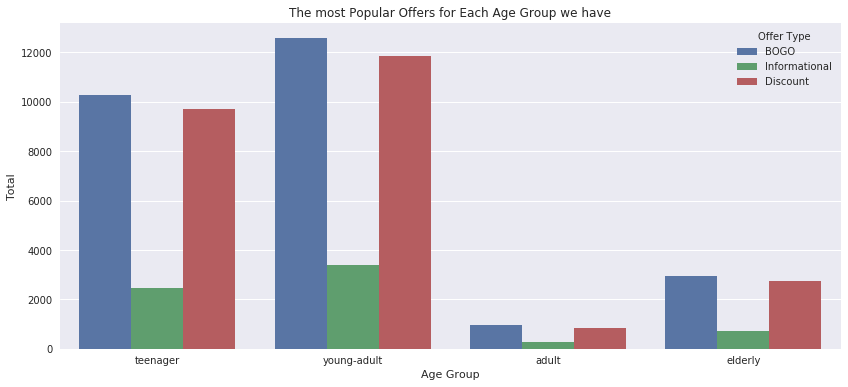

In [88]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="offer_type", data=master_df)
plt.title('The most Popular Offers for Each Age Group we have')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['teenager','young-adult','adult','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

In [89]:
master_df['membership_year'] = master_df['membership_year'].astype(int)

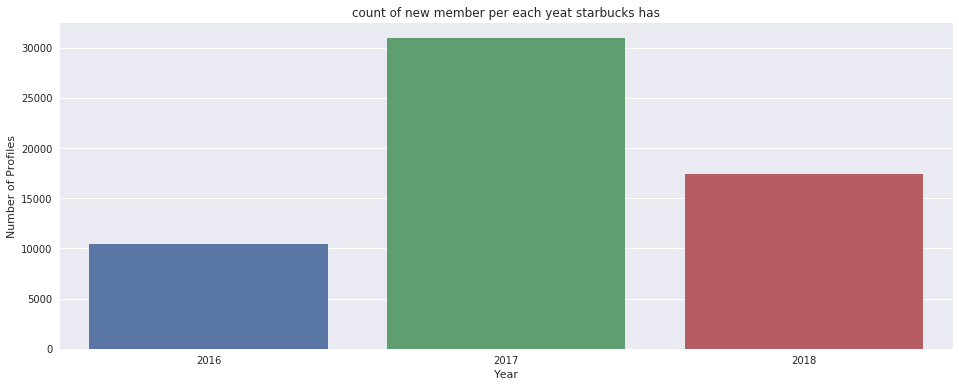

In [90]:
plt.figure(figsize=(16, 6))
sns.countplot(master_df['membership_year'])
plt.title('count of new member per each yeat starbucks has')
plt.ylabel('Number of Profiles')
plt.xlabel('Year')
plt.xticks()
plt.show();

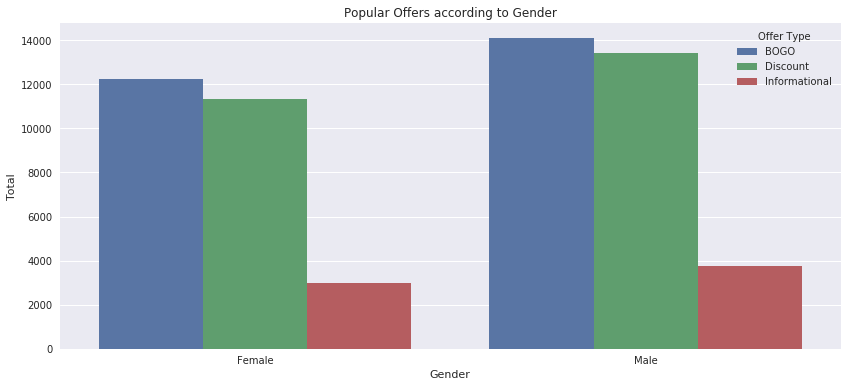

In [91]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="offer_type", data= master_df[master_df["gender"] != 3])
plt.title('Popular Offers according to Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

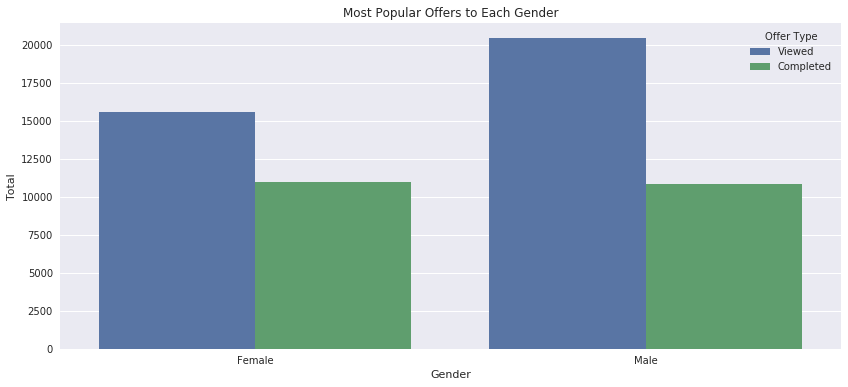

In [92]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= master_df[master_df["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

In [93]:
#Finding form all 'offer viewed' how many 'complete'
total_trans_g_o = master_df[master_df["gender"] != 3].groupby(['gender','offer_type']).count()
total_trans_g_e = master_df[master_df["gender"] != 3].groupby(['gender','event']).count()
total_trans_go_o_t = total_trans_g_o.loc[(1)]['event'].sum()
total_trans_go_o_tt = total_trans_g_o.loc[(2)]['event'].sum()
total_trans_go_o_t_offers_f = total_trans_g_o.loc[(1)].loc[['BOGO', 'Discount', 'Informational']]['event'].sum()
total_trans_go_o_t_offers_m = total_trans_g_o.loc[(2)].loc[['BOGO', 'Discount', 'Informational']]['event'].sum()

In [94]:
print('Finding form all offer viewed how many complete')
print('For Males:')
print(f"Number of offer viewed: {total_trans_g_e.loc[(2, 'Viewed')].values[0]}.")
print(f"Number of offer completed: {total_trans_g_e.loc[(2, 'Completed')].values[0]}, {round((total_trans_g_e.loc[(2, 'Completed')].values[0]/total_trans_g_e.loc[(2, 'Viewed')].values[0])*100,2)}% of total offers viewed.")
print('For Females:')
print(f"Number of offer viewed: {total_trans_g_e.loc[(1, 'Viewed')].values[0]}.")
print(f"Number of offer completed: {total_trans_g_e.loc[(1, 'Completed')].values[0]}, {round((total_trans_g_e.loc[(1, 'Completed')].values[0]/total_trans_g_e.loc[(1, 'Viewed')].values[0])*100,2)}% of total offers viewed.")
print("\n")

Finding form all offer viewed how many complete
For Males:
Number of offer viewed: 20432.
Number of offer completed: 10833, 53.02% of total offers viewed.
For Females:
Number of offer viewed: 15569.
Number of offer completed: 10979, 70.52% of total offers viewed.




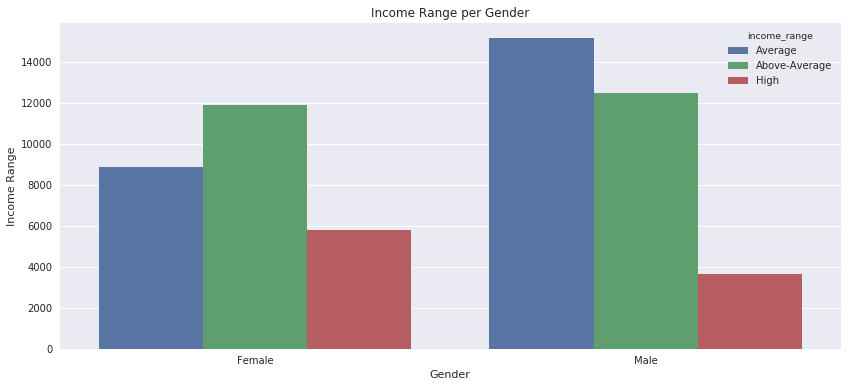

In [95]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="gender", hue="income_range", data= master_df[master_df["gender"] != 3])
plt.title('Income Range per Gender')
plt.ylabel('Income Range')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

In [96]:
# We need to replace the categorical values to numerical values before we complete
labels_event1 = master_df['event'].astype('category').cat.categories.tolist()
replace_map_comp_event1 = {'event' : {k: v for k,v in zip(labels_event1,list(range(1,len(labels_event1)+1)))}}

labels_income1 = master_df['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range1 = {'income_range' : {k: v for k,v in zip(labels_income1,list(range(1,len(labels_income1)+1)))}}

labels_offer_type1 = master_df['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type1 = {'offer_type' : {k: v for k,v in zip(labels_offer_type1,list(range(1,len(labels_offer_type1)+1)))}}

master_df.replace(replace_map_comp_event1, inplace=True)
master_df.replace(replace_map_comp_offer_type1, inplace=True)
master_df.replace(replace_map_comp_income_range1, inplace=True)
master_df.replace(replace_map_comp_age_group, inplace=True)

In [97]:
master_df.head()

,event,customer_id,time,offer_id,amount,reward_x,difficulty,duration_h,offer_type,reward_y,channel_email,channel_mobile,channel_social,channel_web,gender,age_group,income_range,member_type,membership_year
0,2,3729,0,9,0,0,0.25,120,1,0.5,1,1,1,1,2.0,4,2,3,2018
1,2,13995,0,6,0,0,0.00,72,3,0.0,1,1,1,0,3.0,3,2,3,2017
2,2,1052,0,5,0,0,0.50,120,1,1.0,1,1,1,1,1.0,4,2,3,2016
3,2,170,0,8,0,0,0.50,168,1,1.0,1,1,1,0,1.0,1,2,3,2016
7,2,9372,0,2,0,0,0.35,168,2,0.3,1,1,1,1,1.0,3,1,3,2016


<h2>Data Modeling </h2>

We will build a model that can predict how the customer respond to offers

Will need target the columns :
    <li> Event columns that countain ('offer completed','offer viewed')

In [98]:
#but First we need to change the reward_x columns name into reward
master_df.rename(columns ={'reward_x':'reward'}, inplace = True)

In [99]:
master_df.columns

Index(['event', 'customer_id', 'time', 'offer_id', 'amount', 'reward',
       'difficulty', 'duration_h', 'offer_type', 'reward_y', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'gender',
       'age_group', 'income_range', 'member_type', 'membership_year'],
      dtype='object')

In [100]:
# Split the data into features and target label
X = master_df[['offer_id','amount','reward','difficulty','duration_h','offer_type','gender','age_group','income_range', 'member_type']]
Y = master_df['event']

In [101]:
scaler = MinMaxScaler()
features = ['amount', 'reward', 'duration_h']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,offer_id,amount,reward,difficulty,duration_h,offer_type,gender,age_group,income_range,member_type
0,9,0.0,0.0,0.25,0.285714,1,2.0,4,2,3
1,6,0.0,0.0,0.00,0.000000,3,3.0,3,2,3
2,5,0.0,0.0,0.50,0.285714,1,1.0,4,2,3
3,8,0.0,0.0,0.50,0.571429,1,1.0,1,2,3
7,2,0.0,0.0,0.35,0.571429,2,1.0,3,1,3


In [102]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [108]:
#will make a measurment for the accuracy for model
def predict_acc_score(model):
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

In [116]:
#Decision Tree model

dectre = DecisionTreeClassifier()

dectre.fit(X_train, y_train)
print(f'Accuracy for Decision Tree classifier on training set: {round(dectre.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_acc_score(dectre)}%')

Accuracy for Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


In [117]:
# Naive Bayes modle
NivBas = GaussianNB() 
NivBas.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(NivBas.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_acc_score(NivBas)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


<h2>Observation :</h2>

We can see from the function result that our model affter being fitting is score 100% of trainning and testing for each one of them

<h2>Conclusion :</h2>
<li>I found this project challenging, mainly due to the structure of the data in the transcript dataset.
<li> I have explored each dataset, visualize it to get an overall understanding on the data
<li>Preprocessing Data was the task that took most of the time and effort
<li>The dataset is a bit tricky required me to use my wrangling/ engineering and preprocessing skills
<li>I have created two types of model to make sure of result and compare 

In [118]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Starbucks_Capstone_notebook.ipynb to html',
 '[NbConvertApp] Writing 591545 bytes to Starbucks_Capstone_notebook.html',
 '[NbConvertApp] Converting notebook Starbucks_Capstone_notebook-zh.ipynb to html',
 '[NbConvertApp] Writing 279110 bytes to Starbucks_Capstone_notebook-zh.html']